# Recommender systems in streaming environment

In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams["axes.facecolor"] = 'w'

In [2]:
from experiment import Runner
exp = Runner()

### Check the distribution of a 'time' feature

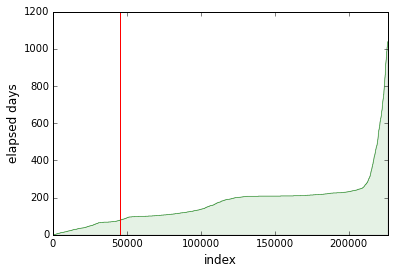

In [4]:
fig, ax = plt.subplots()
ax.plot(exp.dts, c='g', lw=.5)
ax.set_xlim((0, exp.n_sample-1))
ax.fill_between(np.arange(exp.n_sample), np.array(exp.dts), facecolor='g', alpha=0.1)

# 20% pre-train | 80% evaluate
ax.axvline(x=exp.n_train, linewidth=1, linestyle='-', color='red')

ax.set_xlabel('index')
ax.set_ylabel('elapsed days')
plt.show()

### Plot-related preparation

In [5]:
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [6]:
def plot_setting(fig, ax, head=0):
    ax.set_xlabel('index', fontsize=11)
    ax.set_ylabel('recall@10', fontsize=11)
    ax.yaxis.grid(True)
    #ax.set_xticks([0, 50000, 100000, 150000])
    ax.set_yticks([0.00, 0.025, 0.05, 0.075, 0.10])
    #ax.set_xlim([-5000.0, 180000])
    ax.set_ylim([0.0, 0.10])
    
    # 20% pre-train | 80% evaluate
    ax.axvline(x=head, linewidth=1, linestyle='--', color=colors[14])
    
    # head-of-evaluate | first 5000 samples (1st window)
    ax.axvline(x=head+5000-1, linewidth=1, linestyle='--', color=colors[14])
    
    fig.set_size_inches((5.5,3))
    fig.patch.set_alpha(0.0)

In [7]:
def show_result(path):
    with open(path) as f:
        lines = map(lambda l: float(l.rstrip()), f.readlines())
        time = lines[0]
        avgs = lines[1:]
        
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(avgs)), avgs)
    plot_setting(fig, ax)
    
    return avgs, time

## Evaluation methodology

Following paper describes how we can evaluate recommender systems in streaming environments.

J. Vinagre, et al., "**Evaluation of Recommender Systems in Streaming Environments**," Proc. of REDD 2014, Oct. 2014.

The key idea is a *test-then-learn* procedure. To give an example, for the Movielens-1M dataset, the authors set the following evaluation procedure with positive-only setting (i.e. use only positive "5" ratings):

1. Initialize a model with the first 20% events.
2. Observe an evant *(user, item, rating)* one-by-one.
    - If *user* is already known:
        - generate recommendation list and check if *item* is in the list (i.e. compute **recall@10**).
        - compute Simple Moving Average (SMA) of **recall@10** for the most recent $n=5000$ events.
3. Update the model based on the observed event, and proceed 2.

### Baseline

train 20% and use the model for all new observations

0.000538817241836

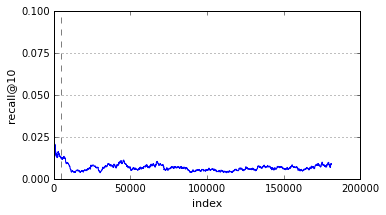

In [8]:
base_avgs, base_time = show_result('results/baseline.txt')
base_time

### Incremental Matrix Factorization (iMF)

- Run a test-then-learn procedure
- Simple Moving Average (SMA) with window size $n=5000$

0.000504606618134

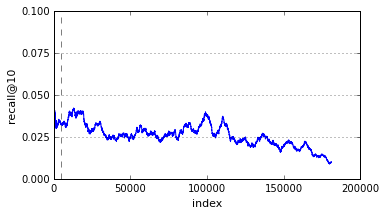

In [9]:
iMF_avgs, iMF_time = show_result('results/iMF.txt')
iMF_time

### Incremental Biased Matrix Factorization (Biased-iMF)

As one specific case of Factorization Machines.

Regularization parameters for the bias terms are updated adaptively.

0.00060325230878

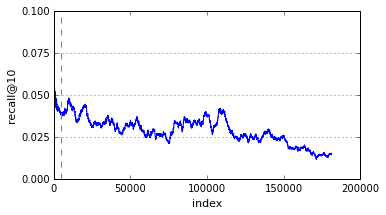

In [10]:
biased_iMF_avgs, biased_iMF_time = show_result('results/biased-iMF.txt')
biased_iMF_time

### Incremental Factorization Machines (no context)

Naive implementation of FMs in incremental fashion with mimicking Biased-iMF

### Incremental Factorization Machines (with context; time-awared)

### Compare the result

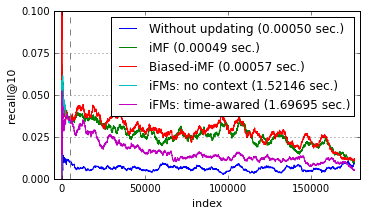

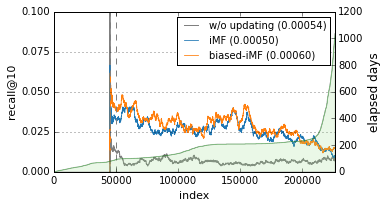

In [11]:
fig, ax = plt.subplots()
x = np.arange(len(base_avgs))+exp.n_train
ax.plot(x, base_avgs, c=colors[14], label='w/o updating (%.5f)' % base_time)
ax.plot(x, iMF_avgs, c=colors[0], lw=.8, label='iMF (%.5f)' % iMF_time)
ax.plot(x, biased_iMF_avgs, c=colors[2], lw=.8, label='biased-iMF (%.5f)' % biased_iMF_time)
#ax.plot(np.arange(len(ifms_no_ctx_avgs))+n_train, ifms_no_ctx_avgs, c=colors[8], lw=.8, label='iFMs: no context (%.5f)' % ifms_no_ctx_time)

# colors 8, 12, 18

plot_setting(fig, ax, exp.n_train-1)
ax.legend(fontsize=10)

# check the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp.dts, c=colors[4], lw=.4)
ax2.set_xlim((0, exp.n_sample-1))
ax2.fill_between(np.arange(exp.n_sample), np.array(exp.dts), facecolor=colors[5], alpha=0.2)

ax2.set_ylabel('elapsed days')

plt.tight_layout()
fig.savefig('../../paper/images/jsai-2016-ml-1m-recall.pdf')